In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from pathlib import Path

## Processing Function
This function processes HAADF line profile data with configurable parameters for different layer spacings

In [7]:
def process_and_plot(csv_filename, output_filename, plot_title='', use_reversed_layers=False,
                     window_length=7, polynomial_order=3, min_distance_nm=1.5, 
                     prominence=500, width_range=None, label_fontsize=26, tick_fontsize=26):
    """
    Process HAADF line profile data and create interlayer distance plot.
    
    Parameters:
    -----------
    csv_filename : str
        Name of the CSV file in the data folder
    output_filename : str
        Name for the output PNG file
    plot_title : str
        Title for the plot (can be empty)
    use_reversed_layers : bool
        If True, use layer_indices starting from 0 (for top), 
        if False, use layer_indices starting from 1 (for bottom)
    window_length : int
        Window length for Savitzky-Golay filter
    polynomial_order : int
        Polynomial order for Savitzky-Golay filter
    min_distance_nm : float
        Minimum distance between peaks in nanometers
    prominence : float
        Prominence threshold for peak detection
    width_range : tuple or None
        (min, max) width range for peaks in nanometers. If None, width constraint is not used.
    label_fontsize : int
        Font size for axis labels
    tick_fontsize : int
        Font size for tick labels
    """
    # Read the CSV file using relative path
    csv_path = Path('data') / csv_filename
    df = pd.read_csv(csv_path, skiprows=2)
    df.columns = ['Position', 'Intensity']
    
    # Convert position to nanometers (from meters)
    df['Position'] = df['Position'] * 1e9  # Convert to nm
    
    # Apply Savitzky-Golay filter to smooth the data
    smoothed_intensity = savgol_filter(df['Intensity'], window_length, polynomial_order)
    
    # Find peaks with parameters adjusted for layer spacing
    points_per_nm = len(df) / (df['Position'].max() - df['Position'].min())
    min_distance = int(min_distance_nm * points_per_nm)
    
    # Build peak finding parameters
    peak_params = {
        'distance': min_distance,
        'prominence': prominence
    }
    
    # Add width constraint only if specified
    if width_range is not None:
        peak_params['width'] = (int(width_range[0]*points_per_nm), 
                                int(width_range[1]*points_per_nm))
    
    peaks, peak_properties = find_peaks(smoothed_intensity, **peak_params)
    
    # Calculate interlayer distances
    peak_positions = df['Position'].iloc[peaks]
    interlayer_distances = np.diff(peak_positions)
    
    print(f"Processing {csv_filename}:")
    print(f"  Found {len(peaks)} peaks")
    print(f"  Interlayer distances: {interlayer_distances}")
    
    # Create figure
    plt.figure(figsize=(6, 10))
    
    # Create layer indices based on the use_reversed_layers flag
    if use_reversed_layers:
        # Top figure: starts from 0
        layer_indices = np.arange(len(interlayer_distances))
        plt.plot(interlayer_distances, layer_indices, 'bo-', alpha=0.5)
        
        # Add trend line (fit interlayer_distances vs layer_indices)
        z = np.polyfit(interlayer_distances, layer_indices, 1)
        p = np.poly1d(z)
        plt.plot(interlayer_distances, p(interlayer_distances), 'r-')
    else:
        # Bottom figure: starts from 1
        layer_indices = np.arange(1, len(interlayer_distances) + 1)
        plt.plot(interlayer_distances, layer_indices, 'bo-', alpha=0.5)
        
        # Fit the trend line with x and y swapped
        z = np.polyfit(layer_indices, interlayer_distances, 1)
        p = np.poly1d(z)
        
        # Create a sequence of points for the trend line
        y_line = np.linspace(min(layer_indices), max(layer_indices), 100)
        x_line = p(y_line)
        
        # Plot the trend line
        plt.plot(x_line, y_line, 'r-')
    
    plt.gca().invert_yaxis()
    
    plt.ylabel('Layer Number', fontsize=label_fontsize)
    plt.xlabel('Interlayer Distance (nm)', fontsize=label_fontsize)
    plt.grid(True)
    
    # Get current x-tick locations and set every other one
    current_ticks = plt.xticks()[0]  # Get current tick locations
    plt.xticks(current_ticks[::2], fontsize=tick_fontsize)  # Set every other tick
    plt.yticks(fontsize=tick_fontsize)
    
    if plot_title:
        plt.title(plot_title, fontsize=label_fontsize)
    
    plt.tight_layout()
    
    # Save figure using relative path
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return peak_positions, interlayer_distances

## 4nm Bilayer Analysis
Process the 4nm bilayer HAADF line profile data (top and bottom)

Processing 20250215 1719 710 kx 140 nm HAADF STEM-lp01.csv:
  Found 33 peaks
  Interlayer distances: [2.396649 2.396649 2.39665  2.396651 2.46512  2.5336   2.46513  2.46512
 2.60208  2.60208  2.5336   2.73903  2.67055  2.67055  2.8075   2.73903
 2.67055  2.80751  2.67055  2.87598  2.67055  2.8075   2.73903  2.87598
 3.01293  2.87598  2.94445  2.80751  3.01293  2.94445  2.80751  2.87598 ]


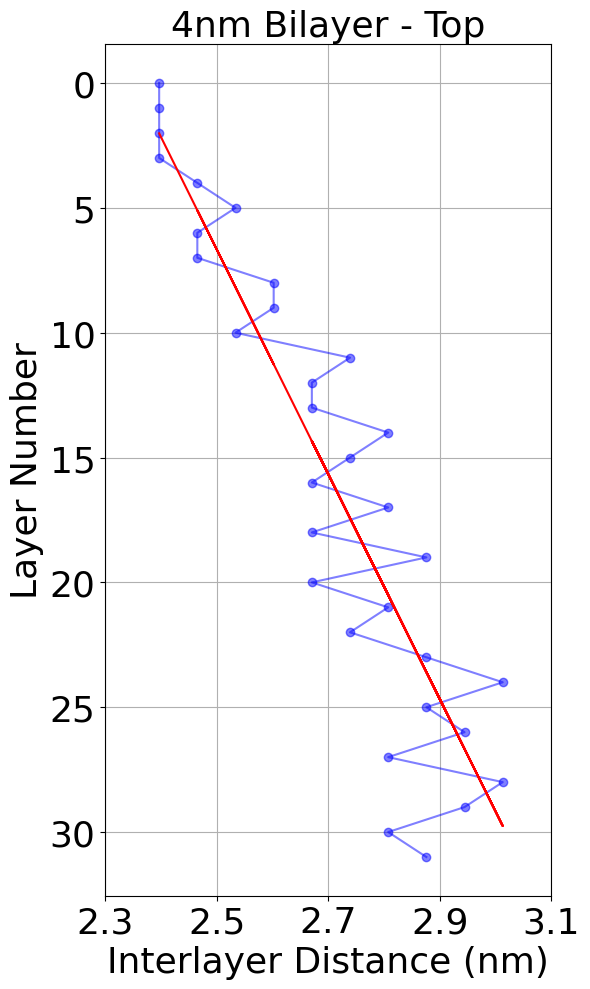

In [8]:
# Process 4nm top figure
peaks_4nm_top, distances_4nm_top = process_and_plot(
    csv_filename='20250215 1719 710 kx 140 nm HAADF STEM-lp01.csv',
    output_filename='HAADF_Line_profile_4nm_top_fig02.png',
    plot_title='4nm Bilayer - Top',
    use_reversed_layers=True,
    window_length=7,
    polynomial_order=3,
    min_distance_nm=1.5,
    prominence=500,
    width_range=(1, 4),
    label_fontsize=26,
    tick_fontsize=26
)

Processing 20250215 1723 710 kx 140 nm HAADF STEM-lp01.csv:
  Found 33 peaks
  Interlayer distances: [3.834639 3.697688 3.834641 3.56073  3.83464  3.56074  3.42378  3.69769
 3.69769  3.56073  3.69769  3.83464  3.83464  3.69769  3.69769  3.69768
 3.69769  3.56074  3.83464  3.69768  3.56074  3.83464  3.83464  3.83464
 3.83463  3.69769  3.83465  3.5607   3.8347   3.5607   3.6977   3.9716  ]


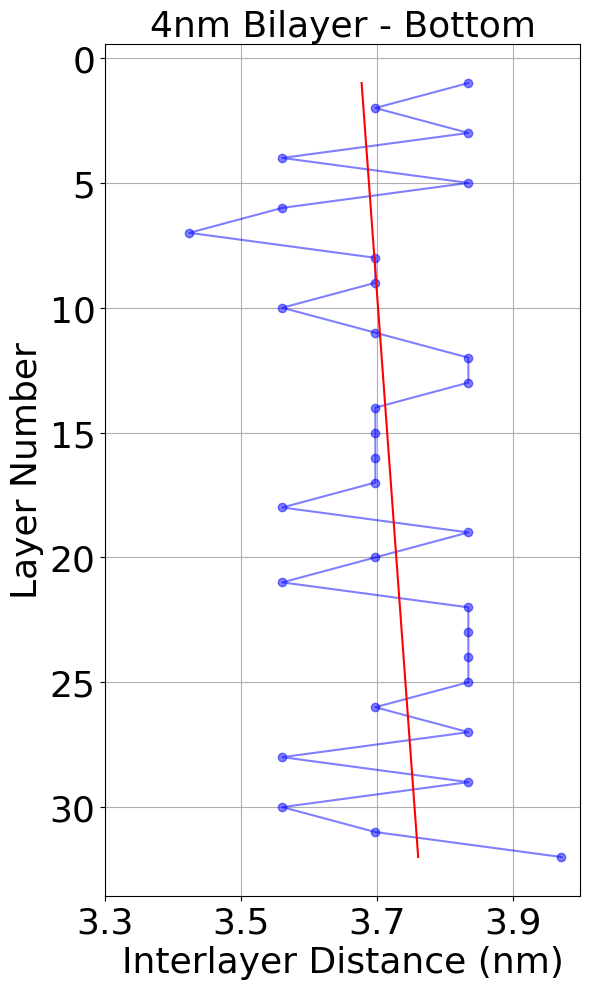

In [9]:
# Process 4nm bottom figure
peaks_4nm_bottom, distances_4nm_bottom = process_and_plot(
    csv_filename='20250215 1723 710 kx 140 nm HAADF STEM-lp01.csv',
    output_filename='HAADF_Line_profile_4nm_bottom_fig01.png',
    plot_title='4nm Bilayer - Bottom',
    use_reversed_layers=False,
    window_length=7,
    polynomial_order=3,
    min_distance_nm=1.5,
    prominence=500,
    width_range=(1, 4),
    label_fontsize=26,
    tick_fontsize=26
)

## 40nm Bilayer Analysis
Process the 40nm bilayer HAADF line profile data with adjusted parameters for larger spacing

Processing 1444 20250328 89000 x 1.12 µm HAADF STEM_line_profile_haadf.csv:
  Found 25 peaks
  Interlayer distances: [20.82841 20.82841 23.02088 24.66518 24.6653  26.3095  28.5021  29.0501
 29.5983  29.5983  30.6945  30.6945  30.6945  30.1464  31.7907  31.7907
 31.7908  32.3388  33.4351  32.887   35.0794  35.0794  35.0795  35.6275 ]


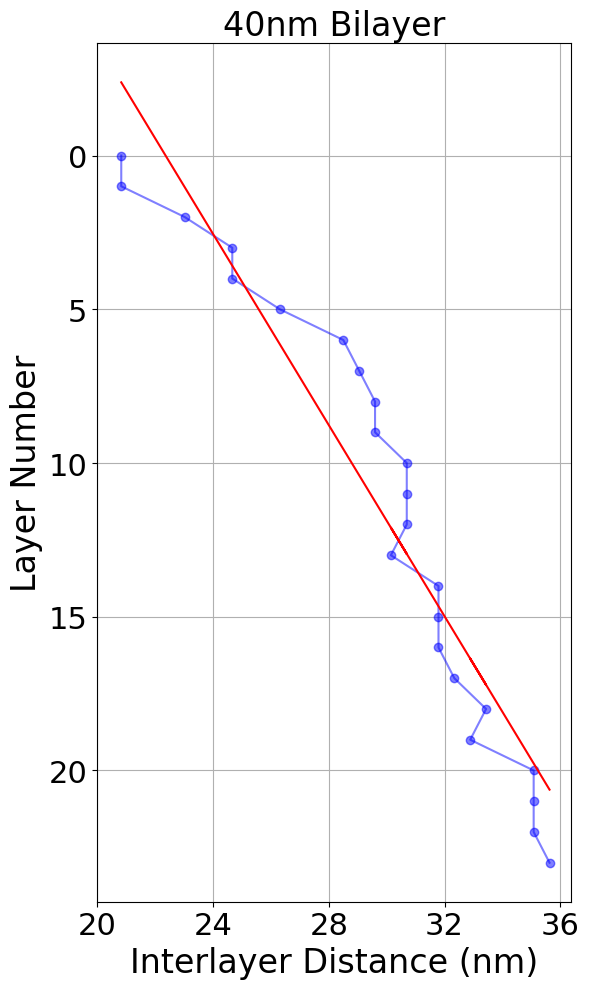

In [10]:
# Process 40nm figure
peaks_40nm, distances_40nm = process_and_plot(
    csv_filename='1444 20250328 89000 x 1.12 µm HAADF STEM_line_profile_haadf.csv',
    output_filename='HAADF_Line_profile_40nm_fig.png',
    plot_title='40nm Bilayer',
    use_reversed_layers=True,
    window_length=4,
    polynomial_order=2,
    min_distance_nm=15,
    prominence=5,
    width_range=None,  # No width constraint for 40nm (as in original notebook)
    label_fontsize=24,
    tick_fontsize=22
)

## Optional: View Smoothed Intensity Profile
Visualize the smoothed intensity data to verify peak detection (useful for troubleshooting)

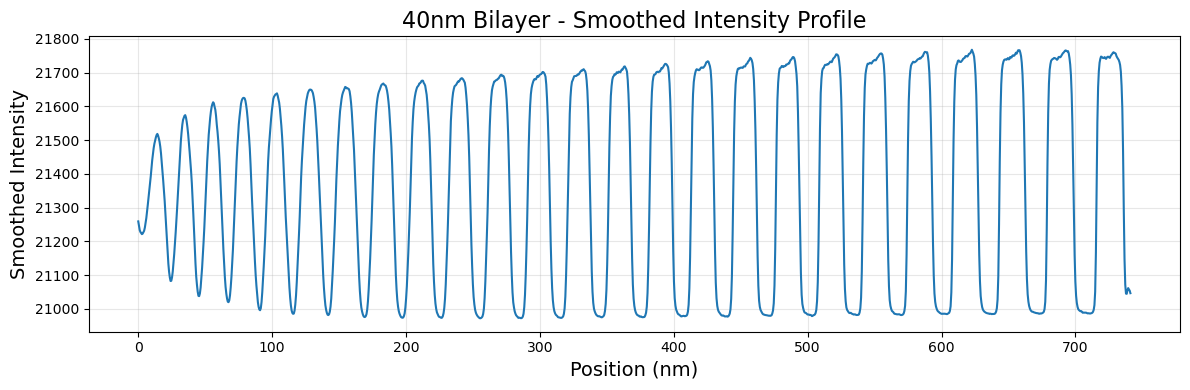

In [6]:
# Example: Plot smoothed intensity for 40nm data
df_40nm = pd.read_csv('data/1444 20250328 89000 x 1.12 µm HAADF STEM_line_profile_haadf.csv', skiprows=2)
df_40nm.columns = ['Position', 'Intensity']
df_40nm['Position'] = df_40nm['Position'] * 1e9

smoothed_40nm = savgol_filter(df_40nm['Intensity'], 4, 2)

plt.figure(figsize=(12, 4))
plt.plot(df_40nm['Position'], smoothed_40nm)
plt.xlabel('Position (nm)', fontsize=14)
plt.ylabel('Smoothed Intensity', fontsize=14)
plt.title('40nm Bilayer - Smoothed Intensity Profile', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()